# Anaysis: Sep W3

## Problem statement: Given opinion as an input, generate outputs which can be classified into 5 tasks
- Given Opinion(input), 
    - Task 1: generate Opinion Summary(output)
    - Task 2: generate Primary Holding(output)
    - Task 3: generate Facts of the case(output)
    - Task 4: generate Question(output)
    - Task 5: generate Conclusion(output)

## Issues
- 1) Opinion is too long that scraping fails to include all opinions
    - Completed, load pickle file instead
    
    
- 2) Null values exists, and sometimes there are too many null counts for some tasks
    - Completed, for now we use only non-null dataset
      - For example, task1 has only 1460 complete set to train(17.7%), while there are 8235 examples in total
      - Suggestion: just use this avilable sets and maybe we can use null rows as a test set 
      - If so, We need some human resources(i.e. lawyers) to see if the result of a test set is okay

#### Basic setting

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_colwidth', 30)

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!pip3 install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 5.4 MB/s 


In [6]:
# load by pandas 
# also use grenne cluster
import pickle5 as pickle

with open('gdrive/My Drive/DSGA1006_capstone/codes/data/NYU_Oyez_data.pkl', 'rb') as f:
    oyez = pickle.load(f)

oyez.head()

,name,href,docket_number,term,description,justia_url,file_name_oyez,file_name_justia,facts_of_the_case,question,conclusion,Justia_summary,Justia_holding,Justia_txt,Justia_auth_txt
0,Oklahoma v. Castro-Huerta,https://api.oyez.org/cases...,21-429,2021,A case in which the Court ...,https://supreme.justia.com...,2021_21-429,federal_us_597_21-429,Victor Manuel Castro-Huert...,Do states have the authori...,The federal government and...,Castro-Huerta was convicte...,The federal government and...,"NOTE:Where it is feasible,...",Syllabus &&& Opinion (Kava...
1,Biden v. Texas,https://api.oyez.org/cases...,21-954,2021,A case in which the Court ...,https://supreme.justia.com...,2021_21-954,federal_us_597_21-954,"In 2018, the Trump adminis...",Must the Biden administrat...,The Government’s rescissio...,"In 2019, the Department of...",The rescission of the Migr...,"NOTE:Where it is feasible,...",Syllabus &&& Opinion (Robe...
2,Shoop v. Twyford,https://api.oyez.org/cases...,21-511,2021,A case in which the Court ...,https://supreme.justia.com...,2021_21-511,federal_us_596_21-511,"In 1993, an Ohio jury conv...",May a federal district cou...,A transportation order tha...,Twyford was convicted of a...,A transportation order tha...,"NOTE:Where it is feasible,...",Syllabus &&& Opinion (Robe...
3,Nance v. Ward,https://api.oyez.org/cases...,21-439,2021,A case in which the Court ...,https://supreme.justia.com...,2021_21-439,federal_us_597_21-439,"In 1993, Michael Wade Nanc...",What is the proper legal p...,Title 42 U.S.C. § 1983 is ...,A prisoner who challenges ...,Section 1983 is an appropr...,"NOTE:Where it is feasible,...",Syllabus &&& Opinion (Kaga...
4,Vega v. Tekoh,https://api.oyez.org/cases...,21-499,2021,A case in which the Court ...,https://supreme.justia.com...,2021_21-499,federal_us_597_21-499,Terence Tekoh worked as a ...,Is the use of an un-Mirand...,A violation of the Miranda...,Los Angeles County Deputy ...,A violation of the Miranda...,"NOTE:Where it is feasible,...",Syllabus &&& Opinion (Alit...


### columns

- name: case name
- href: api reference
- docket_number: case number
- term: year
- description: short description (this can be used in summary)
- justia_url: case url
- file_name_oyez: case number
- file_name_justia: case number
- <b> facts_of_the_case: task3 Output </b>
- <b> question: task4 Output </b>
- <b> conclusion: task5 Output </b>
- <b> Justia_summary: task1 Output </b>
- <b> Justia_holding: task2 Output </b>
- <b> Justia_txt: Input  </b>
- Justia_auth_txt: Input explanation

In [7]:
oyez.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8235 entries, 0 to 8234
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               8235 non-null   object
 1   href               8235 non-null   object
 2   docket_number      8235 non-null   object
 3   term               8235 non-null   object
 4   description        1533 non-null   object
 5   justia_url         7961 non-null   object
 6   file_name_oyez     8235 non-null   object
 7   file_name_justia   7961 non-null   object
 8   facts_of_the_case  7524 non-null   object
 9   question           7525 non-null   object
 10  conclusion         7513 non-null   object
 11  Justia_summary     1460 non-null   object
 12  Justia_holding     1278 non-null   object
 13  Justia_txt         7936 non-null   object
 14  Justia_auth_txt    7936 non-null   object
dtypes: object(15)
memory usage: 1.0+ MB


In [8]:
# total dataset: 8235 cases
oyez.shape

(8235, 15)

In [9]:
# no duplicates
oyez.drop_duplicates().shape

(8235, 15)

In [10]:
oyez.nunique()

name                 7929
href                 8235
docket_number        6591
term                   71
description          1531
justia_url           7961
file_name_oyez       8235
file_name_justia     7961
facts_of_the_case    3561
question             3553
conclusion           3542
Justia_summary        782
Justia_holding       1274
Justia_txt           7936
Justia_auth_txt       768
dtype: int64

In [11]:
# checking first case as an example
for col in oyez.columns:
    print(col, oyez.head(1)[col].values)
    print()

name ['Oklahoma v. Castro-Huerta']

href ['https://api.oyez.org/cases/2021/21-429']

docket_number ['21-429']

term ['2021']

description ['A case in which the Court held that a state has concurrent jurisdiction to prosecute non-Natives who commit crimes against Natives on Native American lands.']

justia_url ['https://supreme.justia.com/cases/federal/us/597/21-429/']

file_name_oyez ['2021_21-429']

file_name_justia ['federal_us_597_21-429']

facts_of_the_case ['Victor Manuel Castro-Huerta, a non-Native, was convicted in Oklahoma state court of child neglect, and he was sentenced to 35 years. The victim, his stepdaughter, is Native American, and the crime was committed within the Cherokee Reservation.Castro-Huerta challenged his conviction, arguing that under the Supreme Court’s 2020 decision in McGirt v. Oklahoma, which held that states cannot prosecute crimes committed on Native American lands without federal approval. Oklahoma argued that McGirt involved a Native defendant, whereas

In [12]:
# we can see that opinion is not fully scraped
# https://supreme.justia.com/cases/federal/us/597/21-429/
print(oyez.head(1)['Justia_txt'].values)

['NOTE:Where it is feasible, a syllabus (headnote) will be released, as is being done in connection with this case, at the time the opinion is issued. The syllabus constitutes no part of the opinion of the Court but has been prepared by the Reporter of Decisions for the convenience of the reader. See United States v. Detroit Timber & Lumber Co.,\n200 U.S. 321, 337. SUPREME COURT OF THE UNITED STATES Syllabus Oklahoma v. Castro-Huerta certiorari to the court of criminal appeals of oklahoma No. 21429.Argued April 27, 2022Decided June 29, 2022 In 2015, respondent Victor Manuel Castro-Huerta was charged by the State of Oklahoma for child neglect.  Castro-Huerta was convicted in state court and sentenced to 35 years of imprisonment.  While Castro-Huertas state-court appeal was pending, this Court decided McGirt v. Oklahoma, 591 U.S. ___.  There, the Court held that the Creek Nations reservation in eastern Oklahoma had never been properly disestablished and therefore remained Indian country.

In [13]:
# creating some conditions to check non-null counts
input1 = ~oyez['Justia_txt'].isnull()
task1 = ~oyez['Justia_summary'].isnull()
task2 = ~oyez['Justia_holding'].isnull()
task3 = ~oyez['facts_of_the_case'].isnull()
task4 = ~oyez['question'].isnull()
task5 = ~oyez['conclusion'].isnull()

print('total avilable data(rows): ', oyez.shape[0])
print('task1 available data(rows): {}, percentage: {}%'.format(len(oyez[input1&task1]), \
                                                               round(len(oyez[input1&task1])/oyez.shape[0]*100,2)))
print('task2 available data(rows): {}, percentage: {}%'.format(len(oyez[input1&task2]), \
                                                               round(len(oyez[input1&task2])/oyez.shape[0]*100,2)))
print('task3 available data(rows): {}, percentage: {}%'.format(len(oyez[input1&task3]), \
                                                               round(len(oyez[input1&task3])/oyez.shape[0]*100,2)))
print('task4 available data(rows): {}, percentage: {}%'.format(len(oyez[input1&task4]), \
                                                               round(len(oyez[input1&task4])/oyez.shape[0]*100,2)))
print('task5 available data(rows): {}, percentage: {}%'.format(len(oyez[input1&task5]), \
                                                               round(len(oyez[input1&task5])/oyez.shape[0]*100,2)))

total avilable data(rows):  8235
task1 available data(rows): 1460, percentage: 17.73%
task2 available data(rows): 1278, percentage: 15.52%
task3 available data(rows): 7274, percentage: 88.33%
task4 available data(rows): 7273, percentage: 88.32%
task5 available data(rows): 7272, percentage: 88.31%


In [14]:
## how long is opinion? longer than maximum length: 32,767
oyez['len_Justia_txt'] = oyez['Justia_txt'].apply(lambda x: len(str(x)))

In [15]:
oyez['len_Justia_txt'].value_counts().sort_index()

3          299
198          1
205          1
231          1
257          1
          ... 
713673       1
865062       1
932022       1
1831688      1
2727860      1
Name: len_Justia_txt, Length: 7621, dtype: int64

In [16]:
max(oyez['len_Justia_txt'])

2727860

In [17]:
oyez[oyez['len_Justia_txt'] == 2727860]['justia_url'].values

array(['https://supreme.justia.com/cases/federal/us/491/22/'],
      dtype=object)

In [18]:
## summary: not to long 
oyez['len_Justia_summary'] = oyez['Justia_summary'].apply(lambda x: len(str(x)))

In [19]:
oyez['len_Justia_summary'].value_counts().sort_index()

3       6775
10       679
279        1
455        1
627        1
        ... 
3033       1
3169       1
3281       1
3301       1
3445       1
Name: len_Justia_summary, Length: 585, dtype: int64

In [20]:
max(oyez['len_Justia_summary'])

3445

### Task1: Given Opinion(input) generate Opinion Summary(output)
- How?
- Select any base model(t5, bart, pegasus, etc) 
- Fine-tune with our data
- Check the result (ROUGE score, and by eyeballing)
- If the result is good, then we can apply to the test dataset

In [21]:
# filter by non-null conditions for task1
task1_df = oyez[input1&task1]
task1_df.shape

(1460, 17)

In [22]:
task1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 8221
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   name                1460 non-null   object
 1   href                1460 non-null   object
 2   docket_number       1460 non-null   object
 3   term                1460 non-null   object
 4   description         1023 non-null   object
 5   justia_url          1460 non-null   object
 6   file_name_oyez      1460 non-null   object
 7   file_name_justia    1460 non-null   object
 8   facts_of_the_case   1432 non-null   object
 9   question            1430 non-null   object
 10  conclusion          1432 non-null   object
 11  Justia_summary      1460 non-null   object
 12  Justia_holding      1278 non-null   object
 13  Justia_txt          1460 non-null   object
 14  Justia_auth_txt     1460 non-null   object
 15  len_Justia_txt      1460 non-null   int64 
 16  len_Justia_summary  1460

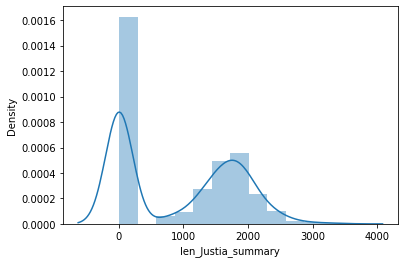

In [23]:
sns.distplot(task1_df['len_Justia_summary'])

In [24]:
task1_df['len_Justia_summary'].value_counts().sort_index()

10      679
279       1
455       1
627       1
654       1
       ... 
3033      1
3169      1
3281      1
3301      1
3445      1
Name: len_Justia_summary, Length: 584, dtype: int64

In [25]:
# Question: if summary is just 'annotation, do we need to take it or not?'
# for now, we exclude those examples (however, those are 1/3 of total dataset)
task1_df[task1_df['len_Justia_summary'] == 10]

,name,href,docket_number,term,description,justia_url,file_name_oyez,file_name_justia,facts_of_the_case,question,conclusion,Justia_summary,Justia_holding,Justia_txt,Justia_auth_txt,len_Justia_txt,len_Justia_summary
481,Thornburgh v. Abbott,https://api.oyez.org/cases...,87-1344,1988,A case in which the Court ...,https://supreme.justia.com...,1988_87-1344,federal_us_490_401,Jack Abbott and other pris...,Does the First Amendment p...,No. Justice Harry A. Black...,Annotation,If it is reasonably relate...,Thornburgh v. Abbott No. 8...,Syllabus &&& Case,78984,10
485,Bolling v. Sharpe,https://api.oyez.org/cases...,8,1940-1955,A case in which the Court ...,https://supreme.justia.com...,1940-1955_347us497,federal_us_347_497,The D.C. Board of Educatio...,Did the segregation of the...,The Fifth Amendment's guar...,Annotation,Mirroring the decision in ...,Bolling v. Sharpe No. 8 Ar...,Syllabus &&& Case,7034,10
486,Brown v. Board of Educatio...,https://api.oyez.org/cases...,1,1940-1955,A case in which the Court ...,https://supreme.justia.com...,1940-1955_347us483,federal_us_347_483,This case was the consolid...,Does the segregation of pu...,Separate but equal educati...,Annotation,The Equal Protection Claus...,Brown v. Board of Educatio...,Syllabus &&& Case,26151,10
499,Youngstown Sheet & Tube Co...,https://api.oyez.org/cases...,744,1940-1955,A case in which the Court ...,https://supreme.justia.com...,1940-1955_343us579,federal_us_343_579,"In April of 1952, during t...",Did the President have the...,"In a 6-to-3 decision, the ...",Annotation,The President cannot take ...,Youngstown Sheet & Tube Co...,Syllabus &&& Case,334621,10
501,Beauharnais v. Illinois,https://api.oyez.org/cases...,118,1940-1955,A case in which the Court ...,https://supreme.justia.com...,1940-1955_343us250,federal_us_343_250,Joseph Beauharnais circula...,Did Beuharnais' conviction...,In a 5-4 opinion authored ...,Annotation,Acts of criminal libel tha...,Beauharnais v. Illinois No...,Syllabus &&& Case,115656,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8190,Miller v. California,https://api.oyez.org/cases...,70-73,1971,A case in which the Court ...,https://supreme.justia.com...,1971_70-73,federal_us_413_15,"Miller, after conducting a...",Is the sale and distributi...,"In a 5-to-4 decision, the ...",Annotation,Speech that is obscene and...,Miller v. California No. 7...,Syllabus &&& Case,72424,10
8191,California Motor Transport...,https://api.oyez.org/cases...,70-92,1971,None,https://supreme.justia.com...,1971_70-92,federal_us_404_508,,,,Annotation,Citizens have the right to...,California Motor Transport...,Syllabus &&& Case,22589,10
8200,Reed v. Reed,https://api.oyez.org/cases...,70-4,1971,A case in which the Court ...,https://supreme.justia.com...,1971_70-4,federal_us_404_71,The Idaho Probate Code spe...,Did the Idaho Probate Code...,"In a unanimous decision, t...",Annotation,Discrimination based on ge...,Reed v. Reed No. 70-4 Argu...,Syllabus &&& Case,12125,10
8220,Fuentes v. Shevin,https://api.oyez.org/cases...,70-5039,1971,None,https://supreme.justia.com...,1971_70-5039,federal_us_407_67,NaN,NaN,NaN,Annotation,Even if the government dep...,Fuentes v. Shevin No. 70-5...,Syllabus &&& Case,78886,10


In [26]:
task1_df[task1_df['len_Justia_summary'] == 10]['justia_url'].values

array(['https://supreme.justia.com/cases/federal/us/490/401/',
       'https://supreme.justia.com/cases/federal/us/347/497/',
       'https://supreme.justia.com/cases/federal/us/347/483/',
       'https://supreme.justia.com/cases/federal/us/343/579/',
       'https://supreme.justia.com/cases/federal/us/343/250/',
       'https://supreme.justia.com/cases/federal/us/341/494/',
       'https://supreme.justia.com/cases/federal/us/340/349/',
       'https://supreme.justia.com/cases/federal/us/340/315/',
       'https://supreme.justia.com/cases/federal/us/336/525/',
       'https://supreme.justia.com/cases/federal/us/336/106/',
       'https://supreme.justia.com/cases/federal/us/334/1/',
       'https://supreme.justia.com/cases/federal/us/333/203/',
       'https://supreme.justia.com/cases/federal/us/330/75/',
       'https://supreme.justia.com/cases/federal/us/330/1/',
       'https://supreme.justia.com/cases/federal/us/326/501/',
       'https://supreme.justia.com/cases/federal/us/325/761/

### removing annoation in summary

In [27]:
# removing rows that has summary as 'annotation'
task1_df = task1_df[task1_df['len_Justia_summary'] != 10]
task1_df.shape

(781, 17)

In [28]:
task1_df.nunique()

name                  772
href                  781
docket_number         781
term                   12
description           779
justia_url            781
file_name_oyez        781
file_name_justia      781
facts_of_the_case     781
question              778
conclusion            781
Justia_summary        781
Justia_holding        600
Justia_txt            781
Justia_auth_txt       492
len_Justia_txt        778
len_Justia_summary    583
dtype: int64

### further analysis on document vs summary

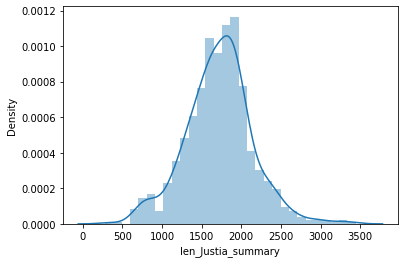

In [29]:
sns.distplot(task1_df['len_Justia_summary'])

In [30]:
np.mean(task1_df['len_Justia_summary']), np.median(task1_df['len_Justia_summary'])

(1718.4443021766965, 1732.0)

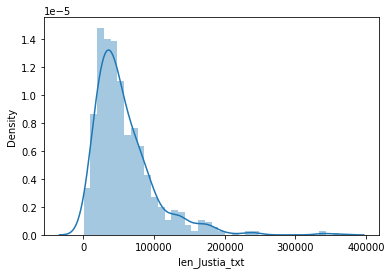

In [31]:
# plot for document length
sns.distplot(task1_df['len_Justia_txt'])

In [32]:
np.mean(task1_df['len_Justia_txt']), np.median(task1_df['len_Justia_txt'])

(58124.763124199744, 46851.0)

In [33]:
# # on average, summary has 3% of contents length on documents
# summary_doc_ratio = np.mean(task1_df['len_Justia_summary']) / np.mean(task1_df['len_Justia_txt'])
# print('summary_doc_ratio: {}%'.format(round(summary_doc_ratio,4)*100))

In [34]:
# on average, summary has 5% of contents length on documents (by each document)
task1_df['sum_txt_ratio'] = task1_df['len_Justia_summary'] / task1_df['len_Justia_txt'] * 100

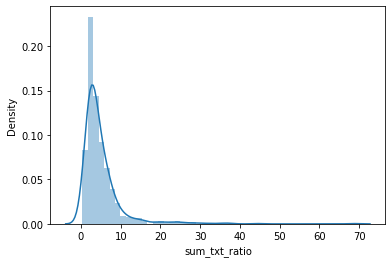

In [35]:
sns.distplot(task1_df['sum_txt_ratio'])

In [36]:
np.mean(task1_df['sum_txt_ratio']), np.median(task1_df['sum_txt_ratio'])

(4.959814268887135, 3.482774893817839)

[]

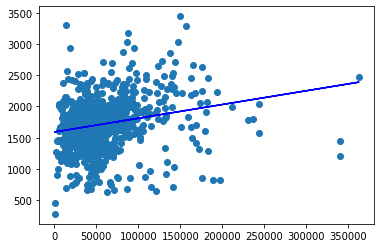

In [37]:
# check to see if doc / summary has any correlation
x = task1_df['len_Justia_txt']
y = task1_df['len_Justia_summary']
a, b = np.polyfit(x, y, deg=1)

plt.scatter(x, y)
plt.plot(x, a*x + b, color='blue')

plt.plot()

In [38]:
# correlation: about 0.226
x = task1_df['len_Justia_txt']
y = task1_df['len_Justia_summary']

r = np.corrcoef(x,y)
r

array([[1.        , 0.22562893],
       [0.22562893, 1.        ]])

### modeling

In [39]:
task1_df_v2 = task1_df[['file_name_oyez', 'Justia_txt', 'Justia_summary', ]]
task1_df_v2.columns = ['id', 'document', 'summary']
task1_df_v2

,id,document,summary
0,2021_21-429,"NOTE:Where it is feasible,...",Castro-Huerta was convicte...
1,2021_21-954,"NOTE:Where it is feasible,...","In 2019, the Department of..."
2,2021_21-511,"NOTE:Where it is feasible,...",Twyford was convicted of a...
3,2021_21-439,"NOTE:Where it is feasible,...",A prisoner who challenges ...
4,2021_21-499,"NOTE:Where it is feasible,...",Los Angeles County Deputy ...
...,...,...,...
3354,2010_09-993,"PLIVA, INC., etal. v. MENS...",These consolidated lawsuit...
3356,2010_10-188,SCHINDLER ELEVATOR CORP. v...,Respondent filed an action...
3357,2010_10-5400,TAPIA v. UNITED STATES cer...,Petitioner was convicted o...
3360,2010_09-1227,BOND v. UNITED STATES cert...,Petitioner was indicted fo...


In [40]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 4.2 MB/s 
     |████████████████████████████████| 7.6 MB 30.6 MB/s 
     |████████████████████████████████| 163 kB 9.8 MB/s 


In [ ]:
## pipeline for bart-base / bart-large (double check: is there bart-small??)
## https://huggingface.co/facebook/bart-base
## https://huggingface.co/docs/transformers/tasks/summarization
## https://huggingface.co/docs/transformers/main/en/task_summary#summarization 

from transformers import BartTokenizer, BartForConditionalGeneration, pipeline

tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")

summarizer = pipeline("summarization", model=model, tokenizer=tokenizer, framework='pt', device=0)
pred = summarizer(task1_df_v2['document'].values.tolist(), min_length=512, max_length=1024, truncation=True)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/558M [00:00<?, ?B/s]

Your max_length is set to 1024, but you input_length is only 233. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=116)
Your max_length is set to 1024, but you input_length is only 976. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=488)
Your max_length is set to 1024, but you input_length is only 1010. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=505)
Your max_length is set to 1024, but you input_length is only 692. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=346)
Your max_length is set to 1024, but you input_length is only 150. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)
Your max_length is set to 1024, but you input_length is only 944. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=472)
Your max_length is set to 1024, but you input_length is only 838

In [ ]:
task1_df_v2['pred'] = pred

In [ ]:
# save checkpoint
file_name = 'gdrive/My Drive/DSGA1006_capstone/codes/result_1012.csv'
task1_df_v2.to_csv(file_name, index=False)

In [48]:
# loading from the checkpoint
file_name = 'gdrive/My Drive/DSGA1006_capstone/codes/result_1012.csv'
task1_df_v2 = pd.read_csv(file_name)
task1_df_v2.head()

,id,document,summary,pred
0,2021_21-429,"NOTE:Where it is feasible,...",Castro-Huerta was convicte...,{'summary_text': 'NOTE:Whe...
1,2021_21-954,"NOTE:Where it is feasible,...","In 2019, the Department of...",{'summary_text': 'NOTE:Whe...
2,2021_21-511,"NOTE:Where it is feasible,...",Twyford was convicted of a...,{'summary_text': 'NOTE:Whe...
3,2021_21-439,"NOTE:Where it is feasible,...",A prisoner who challenges ...,{'summary_text': 'NOTE:Whe...
4,2021_21-499,"NOTE:Where it is feasible,...",Los Angeles County Deputy ...,"{'summary_text': ""NOTE:Whe..."


In [42]:
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.4 MB/s 
     |████████████████████████████████| 432 kB 9.9 MB/s 
     |████████████████████████████████| 115 kB 40.7 MB/s 
     |████████████████████████████████| 212 kB 43.7 MB/s 
     |████████████████████████████████| 127 kB 15.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [43]:
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=623b4aa538b58d5e514f2f279f5d7f1c828fed25f45d9461cd64abf03b32d108
  Stored in directory: /root/.cache/pip/wheels/84/ac/6b/38096e3c5bf1dc87911e3585875e21a3ac610348e740409c76
Successfully built rouge-score


In [47]:
# results are not good as for now 
import evaluate

task1_df_v2['pred'].values

rouge = evaluate.load('rouge')
results = rouge.compute(predictions=task1_df_v2['pred'].values.tolist(), references=task1_df_v2['summary'].values.tolist())
print(results)

{'rouge1': 0.4368751847884612, 'rouge2': 0.2847217116503558, 'rougeL': 0.303305815815745, 'rougeLsum': 0.3035124655276985}


In [44]:
task1_df_v2['pred'].values.tolist()[0]

"{'summary_text': 'NOTE:Where it is feasible, a syllabus (headnote) will be released, as is being done in connection with this case, at the time the opinion is issued. The syllabus constitutes no part of the opinion of the Court but has been prepared by the Reporter of Decisions for the convenience of the reader. See United States v. Detroit Timber & Lumber Co., Inc., 2200 U.S. 321, 337. SUPREME COURT OF THE UNITED STATES Syllabus Oklahoma v. Castro-Huerta certiorari to the court of criminal appeals of oklahoma No. 21429.Argued April 27, 2022Decided June 29, 2022 In 2015, respondent Victor Manuel Castro- Huerta was charged by the State of Oklahoma for child neglect.  He was convicted in state court and sentenced to 35 years of imprisonment.  While Castro-Hertas state-court appeal was pending, this Court decided McGirt v. Oklahoma, 591 U. S. ___.  There, the Court held that the Creek Nations reservation in eastern Oklahoma had never been properly disestablished and therefore remained In

In [45]:
task1_df_v2['summary'].values.tolist()[0]

'Castro-Huerta was convicted of child neglect in Oklahoma state court. The Supreme Court subsequently held that the Creek Nation’s eastern Oklahoma reservation was never properly disestablished and remained “Indian country.” Castro-Huerta then argued that the federal government had exclusive jurisdiction to prosecute him (a non-Indian) for a crime committed against his stepdaughter (Cherokee Indian) in Tulsa (Indian country). The Oklahoma Court of Criminal Appeals vacated his conviction. The Supreme Court reversed. The federal government and the state have concurrent jurisdiction to prosecute crimes committed by non-Indians against Indians in Indian country. States have jurisdiction to prosecute crimes committed in Indian country unless preempted either under ordinary preemption principles, or when the exercise of state jurisdiction would unlawfully infringe on tribal self-government. Neither preempts state jurisdiction in this case.  The General Crimes Act, 18 U.S.C. 1152, does not pr

In [46]:
task1_df_v2['document'].values.tolist()[0]

'NOTE:Where it is feasible, a syllabus (headnote) will be released, as is being done in connection with this case, at the time the opinion is issued. The syllabus constitutes no part of the opinion of the Court but has been prepared by the Reporter of Decisions for the convenience of the reader. See United States v. Detroit Timber & Lumber Co.,\n200 U.S. 321, 337. SUPREME COURT OF THE UNITED STATES Syllabus Oklahoma v. Castro-Huerta certiorari to the court of criminal appeals of oklahoma No. 21429.Argued April 27, 2022Decided June 29, 2022 In 2015, respondent Victor Manuel Castro-Huerta was charged by the State of Oklahoma for child neglect.  Castro-Huerta was convicted in state court and sentenced to 35 years of imprisonment.  While Castro-Huertas state-court appeal was pending, this Court decided McGirt v. Oklahoma, 591 U.S. ___.  There, the Court held that the Creek Nations reservation in eastern Oklahoma had never been properly disestablished and therefore remained Indian country. 

In [ ]:
# manual
# https://huggingface.co/docs/transformers/main/en/task_summary#summarization

max_input_length = max(task1_df['len_Justia_txt']) # 362588
max_target_length = max(task1_df['len_Justia_summary']) # 3445

tokenized_text = [tokenizer.encode(('summarize: '+ input), max_length=1024, return_tensors="pt") for input in task1_df_v2.loc[:, 'document']]
# tokenized_text = task1_df_v2.loc[:, 'document'].apply(lambda x: tokenizer.encode(('summarize: '+ x), max_length=1024, return_tensors="pt"))
print('tokeized success!!')
print('tokenized_text:', tokenized_text, len(tokenized_text[0]))
print()

summary_ids = [model.generate(text, max_length=1024) for text in tokenized_text]
# summary_ids = model.generate(tokenized_text, max_length=1024)
print('summary id success!!')
print('summary_ids:', summary_ids, len(summary_ids[0]))
print()

pred = [tokenizer.decode(summary_id[0], skip_special_tokens=True) for summary_id in summary_ids]
# pred = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print('prediction success!!')
print('pred:', pred, len(pred))
print()

tokeized success!!
tokenized_text: [tensor([[    0, 18581,  3916,  ...,  1292, 21203,     2]]), tensor([[    0, 18581,  3916,  ...,     9,     5,     2]]), tensor([[    0, 18581,  3916,  ...,   281,  7069,     2]]), tensor([[    0, 18581,  3916,  ..., 16840,     7,     2]]), tensor([[    0, 18581,  3916,  ...,  2390,   303,     2]]), tensor([[    0, 18581,  3916,  ...,   172,    12,     2]]), tensor([[    0, 18581,  3916,  ...,    45,  5049,     2]]), tensor([[    0, 18581,  3916,  ...,  1437,    85,     2]]), tensor([[    0, 18581,  3916,  ...,   134,    43,     2]]), tensor([[    0, 18581,  3916,  ...,     4,  1437,     2]]), tensor([[    0, 18581,  3916,  ...,  1138,  4660,     2]]), tensor([[    0, 18581,  3916,  ..., 29609,  5135,     2]]), tensor([[    0, 18581,  3916,  ...,  3450,   250,     2]]), tensor([[    0, 18581,  3916,  ...,     7,   694,     2]]), tensor([[    0, 18581,  3916,  ...,     4,  1261,     2]]), tensor([[    0, 18581,  3916,  ...,     6,    61,     2]]), tens

In [ ]:
max_input_length = max(task1_df['len_Justia_txt']) # 362588
max_target_length = max(task1_df['len_Justia_summary']) # 3445
input = task1_df_v2.loc[1, 'document']
print('input:', input)
print()

tokenized_text = tokenizer.encode(('summarize: '+ input), max_length=1024, return_tensors="pt") # 4096?
print('tokenized_text:', tokenized_text, len(tokenized_text[0]))
print()

summary_ids = model.generate(tokenized_text, max_length=1024) # 4096?
print('summary_ids:', summary_ids, len(summary_ids[0]))
print()

pred = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print('pred:', pred, len(pred))
print()

### fine-tuning

In [ ]:
prefix = "summarize: "

def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["document"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)
    print('input success')

    labels = tokenizer(text_target=examples["summary"].values.tolist(), max_length=128, truncation=True)
    print('label success')

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs # input: input_ids, attention_mask, label: input_ids

In [ ]:
tokenized_task1 = preprocess_function(task1_df_v2)

input success
label success


In [ ]:
tokenized_task1_train = tokenized_task1.iloc[:len(tokenized_task1)*0.8,:]
tokenized_task1_test = tokenized_task1.iloc[len(tokenized_task1)*0.8:,:]

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [ ]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer # AutoModelForSeq2SeqLM

training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    fp16=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_task1_train,
    eval_dataset=tokenized_task1_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

In [ ]:
## send summary results (predictions) - sent
## try small models as well (for all models): i.e. bart-small, t5-small (60M params)
## legal-bert 
## finetune bart-small model: if performs better, than create i.e. legal-bart...
## optimizer: rougeL

## applying existing model

- T5-large: {'rouge1': 0.1329113924050633, 'rouge2': 0.01910828025477707, 'rougeL': 0.08860759493670886, 'rougeLsum': 0.08860759493670886}

- Bart-large: {'rouge1': 0.37269772481040087, 'rouge2': 0.1997828447339848, 'rougeL': 0.24052004333694477, 'rougeLsum': 0.24052004333694477}

- Pegasus-large: {'rouge1': 0.327683615819209, 'rouge2': 0.14204545454545456, 'rougeL': 0.1864406779661017, 'rougeLsum': 0.1864406779661017}

### T5

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 2.1 MB/s 
     |████████████████████████████████| 163 kB 67.8 MB/s 
     |████████████████████████████████| 6.6 MB 30.6 MB/s 


In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 2.1 MB/s 


In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config

model = T5ForConditionalGeneration.from_pretrained('t5-large')
tokenizer = T5Tokenizer.from_pretrained('t5-large')

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

In [ ]:
# max token issue 
max_input_length = max(task1_df['len_Justia_txt'])
max_target_length = max(task1_df['len_Justia_summary'])
print(max_input_length, max_target_length)

362588 3445


In [ ]:
# do we need to divide documents into 88 and make list of summerizations?
362588 / 4096

88.5224609375

In [ ]:
max_input_length = max(task1_df['len_Justia_txt']) # 362588
max_target_length = max(task1_df['len_Justia_summary']) # 3445
input = task1_df_v2.loc[1, 'document']
print('input:', input)
print()

tokenized_text = tokenizer.encode(('summarize: '+ input), max_length=4096, return_tensors="pt")
print('tokenized_text:', tokenized_text, len(tokenized_text[0]))
print()

summary_ids = model.generate(tokenized_text, max_length=4096)
print('summary_ids:', summary_ids, len(summary_ids[0]))
print()

pred = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print('pred:', pred, len(pred))
print()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


input: NOTE:Where it is feasible, a syllabus (headnote) will be released, as is being done in connection with this case, at the time the opinion is issued. The syllabus constitutes no part of the opinion of the Court but has been prepared by the Reporter of Decisions for the convenience of the reader. See United States v. Detroit Timber & Lumber Co.,
200 U.S. 321, 337. SUPREME COURT OF THE UNITED STATES Syllabus biden etal. v. texas etal. certiorari to the united states court of appeals for the fifth circuit No. 21954.Argued April 26, 2022Decided June 30, 2022 In January 2019, the Department of Homeland Security began to implement the Migrant Protection Protocols (MPP).  Under MPP, certain non-Mexican nationals arriving by land from Mexico were returned to Mexico to await the results of their removal proceedings under section 1229a of the Immigration and Nationality Act (INA).  MPP was implemented pursuant to a provision of the INA that applies to aliens arriving on land . . . from a f

In [ ]:
task1_df_v2.loc[1, 'summary']

'In 2019, the Department of Homeland Security implemented the Migrant Protection Protocols (MPP): certain non-Mexican nationals arriving by land from Mexico were returned to Mexico to await the results of their removal proceedings.  Immigration and Nationality Act (INA) section 1225(b)(2)(C) provides: “In the case of an alien ... who is arriving on land ... from a foreign territory contiguous to the United States, the [Secretary] may return the alien to that territory pending a proceeding under section 1229a.”  The Biden administration later suspended the program.  The Fifth Circuit affirmed an order enjoining the termination of MMP.The Supreme Court reversed.   The rescission of MPP did not violate INA section 1225.  The contiguous-territory return authority in section 1225(b)(2)(C) is discretionary and remains discretionary notwithstanding any violation of section 1225(b)(2)(A), which provides for mandatory detention of such aliens.  Since its enactment, every Presidential administra

In [ ]:
pred

'eric liu: court erred in holding that rescission of MPP violated INA, APA. liu: if INA mandated mandatory detention, then it was not a final agency action. he says ad hoc rationalization of decision is not relevant to rescission of policy. liu: if rescission of policy violated INA, then it was not final agency action.'

In [ ]:
# !pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# !pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# results are not good as for now 
import evaluate

rouge = evaluate.load('rouge')
results = rouge.compute(predictions=[pred], references=[task1_df_v2.loc[1, 'summary']])
print(results)

{'rouge1': 0.1329113924050633, 'rouge2': 0.01910828025477707, 'rougeL': 0.08860759493670886, 'rougeLsum': 0.08860759493670886}


In [ ]:
import gc
gc.collect()

0

### Bart

In [ ]:
# bart-base
import torch
from transformers import BartTokenizer, BartForConditionalGeneration

model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')

Downloading:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

In [ ]:
max_input_length = max(task1_df['len_Justia_txt']) # 362588
max_target_length = max(task1_df['len_Justia_summary']) # 3445
input = task1_df_v2.loc[1, 'document']
print('input:', input)
print()

tokenized_text = tokenizer.encode(('summarize: '+ input), max_length=1024, return_tensors="pt")
print('tokenized_text:', tokenized_text, len(tokenized_text[0]))
print()

summary_ids = model.generate(tokenized_text, max_length=1024)
print('summary_ids:', summary_ids, len(summary_ids[0]))
print()

pred = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print('pred:', pred, len(pred))
print()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


input: NOTE:Where it is feasible, a syllabus (headnote) will be released, as is being done in connection with this case, at the time the opinion is issued. The syllabus constitutes no part of the opinion of the Court but has been prepared by the Reporter of Decisions for the convenience of the reader. See United States v. Detroit Timber & Lumber Co.,
200 U.S. 321, 337. SUPREME COURT OF THE UNITED STATES Syllabus biden etal. v. texas etal. certiorari to the united states court of appeals for the fifth circuit No. 21954.Argued April 26, 2022Decided June 30, 2022 In January 2019, the Department of Homeland Security began to implement the Migrant Protection Protocols (MPP).  Under MPP, certain non-Mexican nationals arriving by land from Mexico were returned to Mexico to await the results of their removal proceedings under section 1229a of the Immigration and Nationality Act (INA).  MPP was implemented pursuant to a provision of the INA that applies to aliens arriving on land . . . from a f

In [ ]:
task1_df_v2.loc[1, 'summary']

'In 2019, the Department of Homeland Security implemented the Migrant Protection Protocols (MPP): certain non-Mexican nationals arriving by land from Mexico were returned to Mexico to await the results of their removal proceedings.  Immigration and Nationality Act (INA) section 1225(b)(2)(C) provides: “In the case of an alien ... who is arriving on land ... from a foreign territory contiguous to the United States, the [Secretary] may return the alien to that territory pending a proceeding under section 1229a.”  The Biden administration later suspended the program.  The Fifth Circuit affirmed an order enjoining the termination of MMP.The Supreme Court reversed.   The rescission of MPP did not violate INA section 1225.  The contiguous-territory return authority in section 1225(b)(2)(C) is discretionary and remains discretionary notwithstanding any violation of section 1225(b)(2)(A), which provides for mandatory detention of such aliens.  Since its enactment, every Presidential administra

In [ ]:
len(pred), pred

(4064,
 'Argued April 26, 2022Decided June 30, 2022 In January 2019, the Department of Homeland Security began to implement the Migrant Protection Protocols (MPP).  Under MPP, certain non-Mexican nationals arriving by land from Mexico with Mexico were returned to Mexico to await the results of their removal proceedings under section 1229a of the Immigration and Nationality Act (INA).  MPP was implemented pursuant to a provision of the INA that applies to aliens arriving on land... from a foreign territory contiguous to the United States and provides that the Secretary of Customs and Border Protection (CBP) may return the alien to that territory pending the outcome of a proceeding under the alien’s removal proceedings. See United States v. Detroit Timber & Lumber Co.,200 U.S. 321, 337. 1225(b)(2)(C).  Following a change in Presidential administrations, the Biden administration announced that it would suspend the program, and on June 1, 2021, the Secretary for Homeland Security issued a 

In [ ]:
# results are not good as for now 
import evaluate

rouge = evaluate.load('rouge')
results = rouge.compute(predictions=[pred], references=[task1_df_v2.loc[1, 'summary']])
print(results)

{'rouge1': 0.37269772481040087, 'rouge2': 0.1997828447339848, 'rougeL': 0.24052004333694477, 'rougeLsum': 0.24052004333694477}


In [ ]:
import gc
gc.collect()

446

### Pegasus

In [ ]:
# bart-base
import torch
from transformers import PegasusTokenizer, PegasusForConditionalGeneration

model = PegasusForConditionalGeneration.from_pretrained('google/pegasus-large')
tokenizer = PegasusTokenizer.from_pretrained('google/pegasus-large')

Downloading:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

In [ ]:
max_input_length = max(task1_df['len_Justia_txt']) # 362588
max_target_length = max(task1_df['len_Justia_summary']) # 3445
input = task1_df_v2.loc[1, 'document']
print('input:', input)
print()

tokenized_text = tokenizer.encode(('summarize: '+ input), max_length=1024, return_tensors="pt")
print('tokenized_text:', tokenized_text, len(tokenized_text[0]))
print()

summary_ids = model.generate(tokenized_text, max_length=1024)
print('summary_ids:', summary_ids, len(summary_ids[0]))
print()

pred = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print('pred:', pred, len(pred))
print()

input: NOTE:Where it is feasible, a syllabus (headnote) will be released, as is being done in connection with this case, at the time the opinion is issued. The syllabus constitutes no part of the opinion of the Court but has been prepared by the Reporter of Decisions for the convenience of the reader. See United States v. Detroit Timber & Lumber Co.,
200 U.S. 321, 337. SUPREME COURT OF THE UNITED STATES Syllabus biden etal. v. texas etal. certiorari to the united states court of appeals for the fifth circuit No. 21954.Argued April 26, 2022Decided June 30, 2022 In January 2019, the Department of Homeland Security began to implement the Migrant Protection Protocols (MPP).  Under MPP, certain non-Mexican nationals arriving by land from Mexico were returned to Mexico to await the results of their removal proceedings under section 1229a of the Immigration and Nationality Act (INA).  MPP was implemented pursuant to a provision of the INA that applies to aliens arriving on land . . . from a f

In [ ]:
task1_df_v2.loc[1, 'summary']

'In 2019, the Department of Homeland Security implemented the Migrant Protection Protocols (MPP): certain non-Mexican nationals arriving by land from Mexico were returned to Mexico to await the results of their removal proceedings.  Immigration and Nationality Act (INA) section 1225(b)(2)(C) provides: “In the case of an alien ... who is arriving on land ... from a foreign territory contiguous to the United States, the [Secretary] may return the alien to that territory pending a proceeding under section 1229a.”  The Biden administration later suspended the program.  The Fifth Circuit affirmed an order enjoining the termination of MMP.The Supreme Court reversed.   The rescission of MPP did not violate INA section 1225.  The contiguous-territory return authority in section 1225(b)(2)(C) is discretionary and remains discretionary notwithstanding any violation of section 1225(b)(2)(A), which provides for mandatory detention of such aliens.  Since its enactment, every Presidential administra

In [ ]:
len(pred), pred

(592,
 'The court first concluded that terminating MPP would violate the INA, reasoning that section 1225 of the INA provides the government two options with respect to illegal entrants: mandatory detention pursuant to section 1225(b)(2)(A) or contiguous-territory return pursuant to section 1225(b)(2)(C). Because the Government was unable to meet its mandatory detention obligations under section 1225(b)(2)(A) due to resource constraints, the court reasoned, terminating MPP would necessarily lead to the systemic violation of section 1225 as illegal entrants were released into the United States.')

In [ ]:
# results are not good as for now 
import evaluate

rouge = evaluate.load('rouge')
results = rouge.compute(predictions=[pred], references=[task1_df_v2.loc[1, 'summary']])
print(results)

{'rouge1': 0.327683615819209, 'rouge2': 0.14204545454545456, 'rougeL': 0.1864406779661017, 'rougeLsum': 0.1864406779661017}
